# Data Analysis For Public WiFi Usage.

In [71]:
#Import Library
import pandas as pd
import numpy as np

#Library matplotlib dan seaborn untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

#library untuk data scraping
import requests
from bs4 import BeautifulSoup

#library untuk generate random nama, tanggal, dan choice
import names
import random
from random import randint

#library dasar date and time
import datetime

# 1. Data Creation

Analisis Data dilakukan pada Penggunaan WiFi di Tempat Public / Public Area, untuk specific column terdapat 13 Features/Columns adalah sebagai berikut **Nama Lokasi, Regional, Kecamatan, Jam Login, Nama, Gender, Email, No Telp, Tahun Lahir, Merek HP, Digital Interest, Location Type, Geolocation(Latitude, dan Longitude)**. Untuk Dimension / Shape dari data adalah 1932 Row dan 13 Kolom + Kolom tambahan pada EDA.

## 1.1. Pembuatan Data Lokasi.

Untuk data yang aktual dan relevan, disini akan diambil sebagai contoh beberapa Public Area di Jakarta, data diperoleh dari Scrapping data wikipedia untuk Informasi Detail https://id.wikipedia.org/wiki/Daerah_Khusus_Ibukota_Jakarta di Jakarta terbagi menjadi beberapa regional seperti Jakarta Pusat, Jakarta Timur, Jakarta Barat, Jakarta Utara, dan Jakarta Selatan kemudian untuk per regional tersebut kita bisa mendapatkan informasi kecamatan seperti Gambir, Cakung, Menteng Kemayoran, dll, untuk detail nya ada pada https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta.

In [4]:
url = "https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta"
req = requests.get(url).text

bs = BeautifulSoup(req, 'lxml')
col1 = [] #List menyimpan nilai daerah per index enum
col2 = [] #list menyimpan nilai 

tables = bs.findAll("table", {"class": "wikitable sortable"}) #Cari element table dari html page
daerah = ['Jakarta Pusat','Jakarta Utara','Jakarta Timur','Jakarta Selatan','Jakarta Barat']

for idx, table in enumerate(tables[1:-1]): #hanya ambil index regional jakarta sesuai daerah. (tabel 1-5 only)
    body = table.find('tbody')
    region = daerah[idx]
    for i in body.findAll('tr')[1:-1]:
        items = i.findAll('td')
        col1.append(region)
        col2.append(items[1].a.text)

**Konversi dari List ke DataFrame

In [5]:
df_jkt = pd.DataFrame(list(zip(col1, col2)), columns =['Regional', 'Kecamatan'])

In [6]:
df_jkt.head()

,Regional,Kecamatan
0,Jakarta Pusat,Cempaka Putih
1,Jakarta Pusat,Gambir
2,Jakarta Pusat,Johar Baru
3,Jakarta Pusat,Kemayoran
4,Jakarta Pusat,Menteng


## 1.2 Generate GeoLocation pada Masing Kecamatan.

**Proses ini adalah untuk mendapatkan Lat Long dari kecamatan yang sudah di peroleh, yang nantinya akan dipakai di Foursquare API untuk mendapatkan Venue dengan Range Radius Tertnetu.

In [7]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="test")
#location = geolocator.geocode('Jakarta Pusat, Menteng', timeout=5)
#location.latitude

In [8]:
def LatLongGenerator(df):
    new_df = []
    for index, row in df.iterrows():
        location = geolocator.geocode(row['Regional'] + "," + row['Kecamatan'], timeout=15)
        #Append data to dict
        new_df.append(
            {
                'Regional': row['Regional'],
                'Kecamatan': row['Kecamatan'],
                'Latitude':  location.latitude,
                'Longitude':  location.longitude
            }
        )
    #return the dataframe
    return pd.DataFrame(new_df)
        #print(location.longitude,  location.latitude)

In [9]:
df_Geo = LatLongGenerator(df_jkt)

In [10]:
df_Geo.head()

,Regional,Kecamatan,Latitude,Longitude
0,Jakarta Pusat,Cempaka Putih,-6.181214,106.868548
1,Jakarta Pusat,Gambir,-6.176684,106.830653
2,Jakarta Pusat,Johar Baru,-6.186206,106.857134
3,Jakarta Pusat,Kemayoran,-6.162546,106.856890
4,Jakarta Pusat,Menteng,-6.195026,106.832224


## 1.3 Pembuatan data Venue / Jenis Lokasi.

Kemudian Untuk mendapatkan Venue tiap kecamatan akan digunakan API foursquare https://foursquare.com/developers, dan untuk tiap specific location atau data dapat kita tentukan, seperti School (Elementary School, High School), Hospital, Restaurant (Indonesian Food, American Food, etc), Atau Cafetaria detail untuk kategori API https://developer.foursquare.com/docs/build-with-foursquare/categories/, tetapi untuk simple analysis akan diambil contoh Hanya pada **Cafetaria, Cafe, HighSchool, Indonesian Restorant, Mall, Hospital **.

In [11]:
CLIENT_ID = 'A0S1PZH3QB3SY2OHEOYLRCBE414WK13EVRMHOXTD0BK13PRB' # your Foursquare ID
CLIENT_SECRET = 'AJ2QPTSM1DFFBRJCOEA2HPIKJXXXVANT2ZJ5GGPXD53YMWKL' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ', CLIENT_ID)
print('CLIENT_SECRET:', CLIENT_SECRET)

Your credentails:
CLIENT_ID:  A0S1PZH3QB3SY2OHEOYLRCBE414WK13EVRMHOXTD0BK13PRB
CLIENT_SECRET: AJ2QPTSM1DFFBRJCOEA2HPIKJXXXVANT2ZJ5GGPXD53YMWKL


** Untuk Mendapatkan Venues kita harus memasukkan custom id dari venue yang unik bisa dilihat pada https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [12]:
def getNearbyVenues(df, radius=3000):
    venues_list=[]
    #Kategory yang terpilih adalah:
    #Cafetaria, Cafe, HighSchool, IndoResto, Mall, Hospital
    CATEGORY_ID = "4bf58dd8d48988d128941735,4bf58dd8d48988d16d941735,4bf58dd8d48988d13d941735,4deefc054765f83613cdba6f,5744ccdfe4b0c0459246b4df,4bf58dd8d48988d196941735"
    LIMIT = 50
    for index,row in df.iterrows():
        regional = row["Regional"]
        kecamatan = row["Kecamatan"]
        longitude = row["Longitude"]
        latitude = row["Latitude"]
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT,
            CATEGORY_ID)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            regional,
            kecamatan,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        venues.columns = ['Regional', 'Kecamatan', 'Nama Lokasi', 'Lokasi Latitude', 
                          'Lokasi Longitude', 'Location Type']
    return(venues)

In [13]:
venues = getNearbyVenues(df_Geo)

In [14]:
venues

,Regional,Kecamatan,Nama Lokasi,Lokasi Latitude,Lokasi Longitude,Location Type
0,Jakarta Pusat,Cempaka Putih,Mie ayam pangsit ACOI,-6.176125,106.865826,Indonesian Restaurant
1,Jakarta Pusat,Cempaka Putih,Bakso Ciat Solo,-6.184014,106.866700,Indonesian Restaurant
2,Jakarta Pusat,Cempaka Putih,Nasi Uduk Kebon Kacang Pemuda,-6.192760,106.879872,Indonesian Restaurant
3,Jakarta Pusat,Cempaka Putih,RSIA Evasari,-6.193774,106.859861,Hospital
4,Jakarta Pusat,Cempaka Putih,Rumah Makan Ampera 2 Tak,-6.168764,106.869352,Indonesian Restaurant
...,...,...,...,...,...,...
1927,Jakarta Barat,Kembangan,RS. Sari Asih Ciledug,-6.211414,106.735561,Hospital
1928,Jakarta Barat,Kembangan,The Upside,-6.191277,106.762970,Café
1929,Jakarta Barat,Kembangan,RS Graha Medika Siloam,-6.190462,106.763045,Hospital
1930,Jakarta Barat,Kembangan,4th floor ward - Siloam Hospitals,-6.190899,106.763444,Hospital


**Setelah melakukan request ke API maka didapat Unique Location dari berbagai radius (set_max radius = 3000)

In [15]:
venues['Location Type'].unique()

array(['Indonesian Restaurant', 'Hospital', 'Café', 'High School',
       'Hotel', 'School', "Doctor's Office", 'Medical Center',
       'Cafeteria', 'Multiplex', 'Gas Station',
       'Indonesian Meatball Place', 'Betawinese Restaurant',
       'Historic Site', 'Soup Place', 'Middle School', 'Intersection',
       'Sundanese Restaurant', 'Balinese Restaurant', 'Community College',
       'Padangnese Restaurant', 'Shopping Mall', 'Asian Restaurant',
       'Javanese Restaurant', 'Convenience Store',
       'Residential Building (Apartment / Condo)', 'Movie Theater',
       'Library', 'Building', 'Government Building', 'Office',
       'Grocery Store', 'Acehnese Restaurant'], dtype=object)

## 1.4 User Data Creation (Digital Interest)

Data Digital Interest diambil dari https://en.wikipedia.org/wiki/Social_media.

In [16]:
def DigitalInterest():
    url = "https://en.wikipedia.org/wiki/Social_media"
    req = requests.get(url).text
    dinterest = []
    bs = BeautifulSoup(req, 'lxml')
    heading = bs.find(id='Definition_and_features')
    hobbies = heading.find_next('ul')

    for hobby in hobbies:
        items = hobby.text.upper().replace(',','')
        dinterest.append(items)
        #print(items)
    dinterest = [dinterest.pop(i) for i, v in enumerate(dinterest) if v not in ['\n']] 
    return dinterest

In [17]:
digInterest = DigitalInterest()

In [18]:
digInterest

['BLOGS',
 'COLLABORATIVE PROJECT MANAGEMENT',
 'ENTERPRISE SOCIAL NETWORKING',
 'BUSINESS NETWORKS',
 'FORUMS',
 'MICROBLOGS',
 'PHOTO SHARING',
 'PRODUCTS/SERVICES REVIEW',
 'SOCIAL BOOKMARKING',
 'SOCIAL GAMING',
 'SOCIAL NETWORKS',
 'VIDEO SHARING AND',
 'VIRTUAL WORLDS.']

## 1.5 User Data Creation (Smartphone Sales)

Pada smartphone / Jenis HP didasarkan pada data penjualan / sales smartphone tahun 2010 pada https://en.wikipedia.org/wiki/List_of_best-selling_mobile_phones, setelah itu akan diambil top 5 sales.

In [19]:
def smartphoneSales2010():
    url = "https://en.wikipedia.org/wiki/List_of_best-selling_mobile_phones"
    req = requests.get(url).text

    bs = BeautifulSoup(req, 'lxml')
    col1 = [] #List menyimpan brand
    col2 = [] #list menyimpan Sales pada 2010 

    tables = bs.findAll("table", {"class": "wikitable sortable"}) #Cari element table dari html page

    for idx, table in enumerate(tables): #loop pada table yang terdapat pada page
        body = table.find('tbody')
        if idx == 1: #ambil page saales penjualan
            #print(body)
            for i in body.findAll('tr'):
                tds = i.findAll('td')[0:1] #Kolom brand
                for td in tds:
                    #print(td.text)
                    col1.append(td.text.strip())
                tdb = i.findAll('td')[29:30] #kolom tabel sales 2010
                for td2 in tdb:
                    #print(td.text)
                    col2.append(td2.text.strip())
                    
    return pd.DataFrame(list(zip(col1, col2)), columns =['Brand', 'Sales 2010'])

In [20]:
top5Phone = smartphoneSales2010()

**Remove Total Table

In [27]:
top5Phone = top5Phone.iloc[0:25,:]

**Berdasarkan Statistik bahwa brand paling banyak pengguna adalah Samsung, disusul dengan Apple, dan sisanya adalah kombinasi dari brand lain nya.

In [31]:
top5Phone.sort_values(by=['Sales 2010'],ascending=False)

,Brand,Sales 2010
15,Others,"454,800,000"
18,Samsung,"253,000,000"
1,Apple,"199,800,000"
5,Huawei,"182,600,000"
24,Xiaomi,"145,800,000"
14,Oppo,"111,800,000"
23,Vivo,
22,TCL,
21,Sony Ericsson,
20,Sony,


** Disini Hanya akan diambil Top 6/7 Most Known brand saja

In [34]:
topPhone = top5Phone.sort_values(by=['Sales 2010'],ascending=False)['Brand'][0:7].tolist()

In [35]:
topPhone

['Others', 'Samsung', 'Apple', 'Huawei', 'Xiaomi', 'Oppo', 'Vivo']

**Final Data Untuk Smartphone berdasarkan top Sales.

## 1.6 User Data Creation (Biodata, Jam Login, no HP)

Kemudian untuk data nama dan gender akan menggunakan library dari Python https://pypi.org/project/names-generator/, sedangkan untuk nama akan diambil nama depan + random number + random domain (eg.@gmail.com), untuk Login time dan no HP menggunakan random number generator.

In [37]:
def login_time():    
    rtime = int(random.random()*86400)
    
    hours   = int(rtime/3600)
    minutes = int((rtime - hours*3600)/60)
    seconds = rtime - hours*3600 - minutes*60
    
    time_string = '%02d:%02d:%02d' % (hours, minutes, seconds)
    return time_string

In [36]:
def gen_phone():
    kode = str(62)
    digit1 = str(random.randint(800,888)).zfill(3)

    digit2 = (str(random.randint(1,9998)).zfill(4))
    digit3 = (str(random.randint(1,9998)).zfill(4))

    return '+{}{}-{}-{}'.format(kode,digit1, digit2,digit3)

** Generate User disini adalah fungsi untuk menghasilkan Data menggunakan random. Gender, Nama (Random name), Email (Kombinasi namadepan + angka dan Domain), Tanggal Lahir(Random Dates), dan Merk Ponsel (Random dari Top 6 Sales), Digital Interest (Data dari Scrap Wikipedia),

In [49]:
def generateUser():
    user_df = []
    for i in range(len(venues)):
        gender = ['female','male']
        domain_mail = ['@gmail.com','@ymail.com','@hotmail.com','@rocketmail.com']
        selected_gender = random.choice(gender)
        rand_name = names.get_full_name(gender=selected_gender)
        email_usr = rand_name.split(' ')[0].lower()+str(random.randint(0,150))+random.choice(domain_mail)
        tahun_lahir = datetime.date(randint(1980,2004), randint(1,12),randint(1,28)) #disini untuk usia dibatasi 17-40Tahun
        merk_ponsel = random.choice(topPhone)
        digital_interest = random.choice(digInterest)
        jam_login = login_time()
        no_hp = gen_phone()

        user_df.append(
            {
                'Nama User': rand_name,
                'Email': email_usr,
                'Jam Login' : jam_login,
                'Gender':  selected_gender,
                'No HP':  no_hp,
                'Tahun Lahir':  tahun_lahir,
                'Merk HP':  merk_ponsel,
                'Digital Interest':  digital_interest
            }
        )
    return pd.DataFrame(user_df)

In [50]:
df_user = generateUser()

In [52]:
df_user.head()

,Nama User,Email,Jam Login,Gender,No HP,Tahun Lahir,Merk HP,Digital Interest
0,John Middleton,john99@gmail.com,21:39:34,male,+62842-9727-2313,2001-01-20,Huawei,FORUMS
1,Heather Graff,heather101@ymail.com,06:19:41,female,+62808-9755-8251,1981-11-09,Xiaomi,MICROBLOGS
2,Ralph Emery,ralph70@hotmail.com,14:35:59,male,+62884-1332-6131,1993-04-11,Others,PHOTO SHARING
3,Edward Smith,edward75@ymail.com,14:57:22,male,+62808-7789-5758,2004-04-23,Oppo,VIDEO SHARING AND
4,Christine Compton,christine65@ymail.com,11:50:46,female,+62817-9663-1582,1980-09-21,Apple,SOCIAL GAMING


** Hasil untuk data user, selanjutnya dengan concatenate dengan data venues.

In [55]:
final_df = pd.concat([df_user, venues], axis=1)

**Final Data adalah seperti dibawah ini kemudian dilanjutkan dengan EDA (Exploratory data Analysis).

In [57]:
final_df.head(5)

,Nama User,Email,Jam Login,Gender,No HP,Tahun Lahir,Merk HP,Digital Interest,Regional,Kecamatan,Nama Lokasi,Lokasi Latitude,Lokasi Longitude,Location Type
0,John Middleton,john99@gmail.com,21:39:34,male,+62842-9727-2313,2001-01-20,Huawei,FORUMS,Jakarta Pusat,Cempaka Putih,Mie ayam pangsit ACOI,-6.176125,106.865826,Indonesian Restaurant
1,Heather Graff,heather101@ymail.com,06:19:41,female,+62808-9755-8251,1981-11-09,Xiaomi,MICROBLOGS,Jakarta Pusat,Cempaka Putih,Bakso Ciat Solo,-6.184014,106.866700,Indonesian Restaurant
2,Ralph Emery,ralph70@hotmail.com,14:35:59,male,+62884-1332-6131,1993-04-11,Others,PHOTO SHARING,Jakarta Pusat,Cempaka Putih,Nasi Uduk Kebon Kacang Pemuda,-6.192760,106.879872,Indonesian Restaurant
3,Edward Smith,edward75@ymail.com,14:57:22,male,+62808-7789-5758,2004-04-23,Oppo,VIDEO SHARING AND,Jakarta Pusat,Cempaka Putih,RSIA Evasari,-6.193774,106.859861,Hospital
4,Christine Compton,christine65@ymail.com,11:50:46,female,+62817-9663-1582,1980-09-21,Apple,SOCIAL GAMING,Jakarta Pusat,Cempaka Putih,Rumah Makan Ampera 2 Tak,-6.168764,106.869352,Indonesian Restaurant


# 2. EDA (Exploratory Data Analysis)

## 2.1 Univariative Analysis.

Pada analysis univariate adalah untuk mengetahui begaimana deskripsi, patern, atau summary dari satu masing-masing feature data.

**Check Dataframe

In [58]:
final_df.describe()

,Lokasi Latitude,Lokasi Longitude
count,1932.000000,1932.000000
mean,-6.207122,106.832478
std,0.056574,0.048928
min,-6.352025,106.689155
25%,-6.243381,106.800196
50%,-6.195863,106.833381
75%,-6.165271,106.865434
max,-6.103435,106.962686


** Disini hanya dapat menampilkan numerical (lat,long) data karena beberapa data termasuk categorical / string dan juga kombinasi dengan date time, sehingga diperlukan analisis lanjutan untuk mengolah data kategorical.

**Checking Null Values.

In [60]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 14 columns):
Nama User           1932 non-null object
Email               1932 non-null object
Jam Login           1932 non-null object
Gender              1932 non-null object
No HP               1932 non-null object
Tahun Lahir         1932 non-null object
Merk HP             1932 non-null object
Digital Interest    1932 non-null object
Regional            1932 non-null object
Kecamatan           1932 non-null object
Nama Lokasi         1932 non-null object
Lokasi Latitude     1932 non-null float64
Lokasi Longitude    1932 non-null float64
Location Type       1932 non-null object
dtypes: float64(2), object(12)
memory usage: 211.4+ KB


In [62]:
final_df.isnull().sum()

Nama User           0
Email               0
Jam Login           0
Gender              0
No HP               0
Tahun Lahir         0
Merk HP             0
Digital Interest    0
Regional            0
Kecamatan           0
Nama Lokasi         0
Lokasi Latitude     0
Lokasi Longitude    0
Location Type       0
dtype: int64

**Karena ini data dummy maka tidak terdapat null-values, tetapi dalam real world case pasti ada null values dan diperlukan treatment khusus untuk proses impute (imputasi) data tersebut, yang paling simple adalah : jika data categorical maka isi null values dengan modus, jika numerical values dan tidak terdapat outlier maka ambil mean sebagai impute, dan jika numerical dan terdapat outlier maka ambil median nya.

### Analysis Pengguna Berdasarkan Type Smartphone (Kategorikal Data).

In [67]:
final_df['Merk HP'].unique()

array(['Huawei', 'Xiaomi', 'Others', 'Oppo', 'Apple', 'Vivo', 'Samsung'],
      dtype=object)

In [68]:
final_df['Merk HP'].value_counts()

Vivo       296
Apple      290
Oppo       279
Xiaomi     278
Others     267
Huawei     263
Samsung    259
Name: Merk HP, dtype: int64

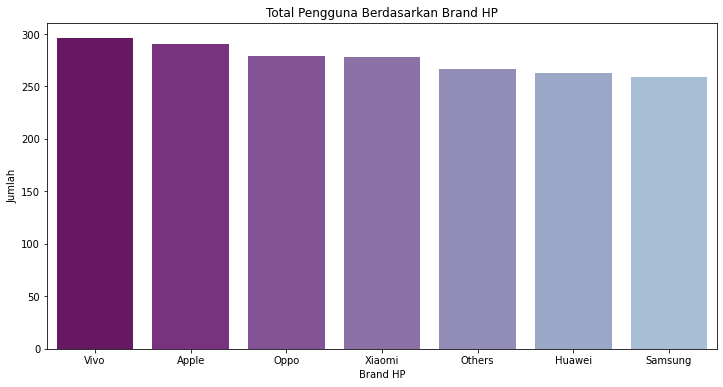

In [323]:
plt.figure(figsize=(12,6))
ax = sns.countplot((final_df['Merk HP']),order = final_df['Merk HP'].value_counts().index,palette=sns.color_palette('BuPu_r', n_colors=10))

# Customize the axes and title
ax.set_title("Total Pengguna Berdasarkan Brand HP")
ax.set_xlabel("Brand HP")
ax.set_ylabel("Jumlah")
plt.savefig('Total Pengguna Berdasarkan Brand HP.png')
plt.show()

Berdasarkan jumlah data di atas Pengguna Vivo memiliki jumlah terbanyak dari semua user, tetapi gap / rentang jumlah satu dan lain nya tidak berbeda jauh.

### Analysis Perbandingan Gender dari Seluruh User.

In [103]:
final_df['Gender'].value_counts()

female    978
male      954
Name: Gender, dtype: int64

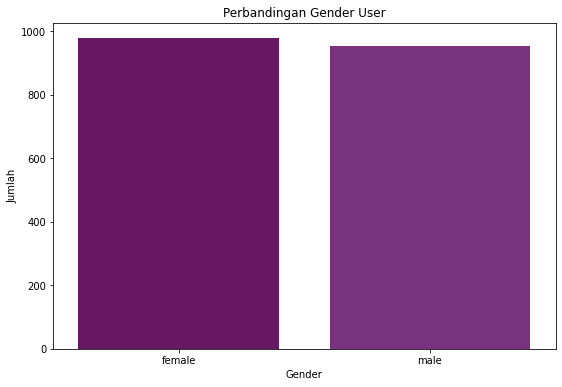

In [324]:
plt.figure(figsize=(9,6))
ax = sns.countplot((final_df['Gender']),order = final_df['Gender'].value_counts().index,palette=sns.color_palette('BuPu_r', n_colors=10))

# Customize the axes and title
ax.set_title("Perbandingan Gender User")
ax.set_xlabel("Gender")
ax.set_ylabel("Jumlah")
plt.savefig('Perbandingan Gender User.png')
plt.show()

** Dalam dataset ini perbandingan jumlah antara gender 'Male' dan 'Female' cukup balance.

### Analysis Digital Interest dari Berbagai User.

In [107]:
final_df['Digital Interest'].unique()

array(['FORUMS', 'MICROBLOGS', 'PHOTO SHARING', 'VIDEO SHARING AND',
       'SOCIAL GAMING', 'VIRTUAL WORLDS.',
       'COLLABORATIVE PROJECT MANAGEMENT', 'SOCIAL NETWORKS',
       'PRODUCTS/SERVICES REVIEW', 'ENTERPRISE SOCIAL NETWORKING',
       'SOCIAL BOOKMARKING', 'BLOGS', 'BUSINESS NETWORKS'], dtype=object)

In [108]:
final_df['Digital Interest'].nunique()

13

**Terdapat 13 Kategori untuk Digital Interest Selanjutnya Plot top 5 dari ke 13 data tersebut.

In [118]:
final_df['Digital Interest'].value_counts().nlargest(5)

SOCIAL BOOKMARKING                  164
VIDEO SHARING AND                   161
VIRTUAL WORLDS.                     160
COLLABORATIVE PROJECT MANAGEMENT    160
FORUMS                              155
Name: Digital Interest, dtype: int64

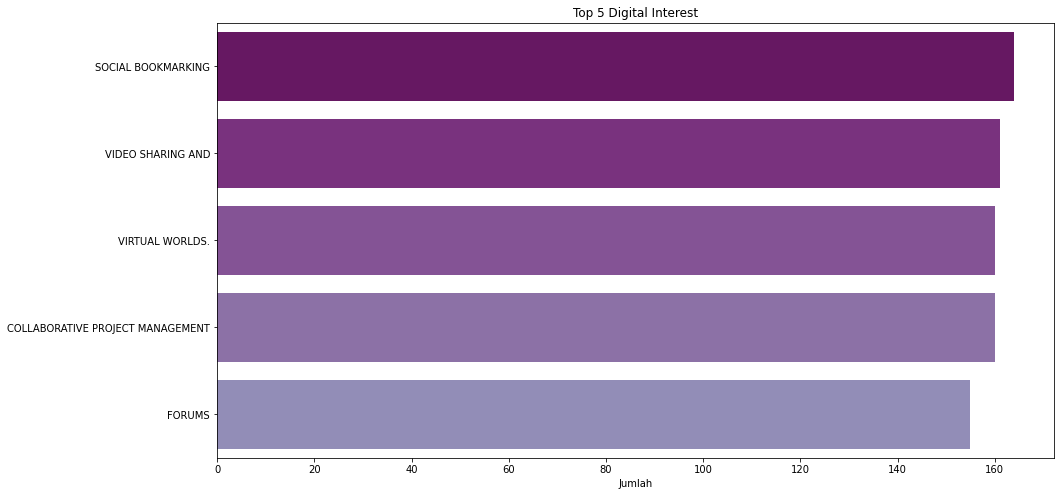

In [393]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=final_df['Digital Interest'].value_counts().nlargest(5),y=final_df['Digital Interest'].value_counts().nlargest(5).index,palette=sns.color_palette('BuPu_r', n_colors=10) )
ax.set_title("Top 5 Digital Interest")
ax.set_xlabel("Jumlah")
plt.savefig('Top 5 Digital Interest.png')
plt.show()

### Analysis Umur Seluruh Pengguna.

In [134]:
from datetime import date
def calculate_age(born):
    #born = datetime.datetime.strptime(born, "%y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

Konversi dari tanggal lahir ke Umur dengan mengurangkan dengan datetime.today

In [135]:
final_df['Umur'] = final_df['Tahun Lahir'].apply(calculate_age)

In [141]:
final_df[['Tahun Lahir','Umur']].head()

,Tahun Lahir,Umur
0,2001-01-20,20
1,1981-11-09,39
2,1993-04-11,28
3,2004-04-23,17
4,1980-09-21,41


In [161]:
final_df['Umur'].describe()

count    1932.000000
mean       28.826087
std         7.134629
min        16.000000
25%        23.000000
50%        29.000000
75%        35.000000
max        41.000000
Name: Umur, dtype: float64

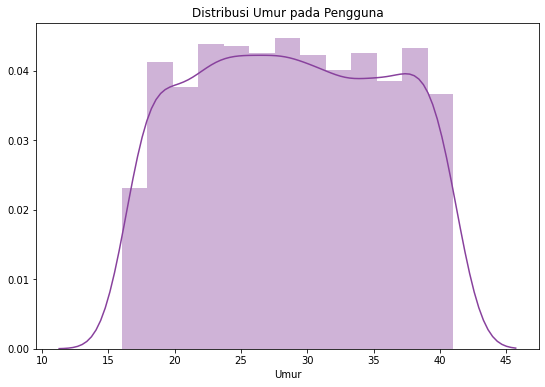

In [397]:
plt.figure(figsize=(9,6))
sns.set_palette(sns.color_palette('BuPu_r', n_colors=3))

ax = sns.distplot(final_df['Umur'])
ax.set_title("Distribusi Umur pada Pengguna")
ax.set_xlabel("Umur")
plt.savefig('Distribusi Umur pada Pengguna.png')
plt.show()

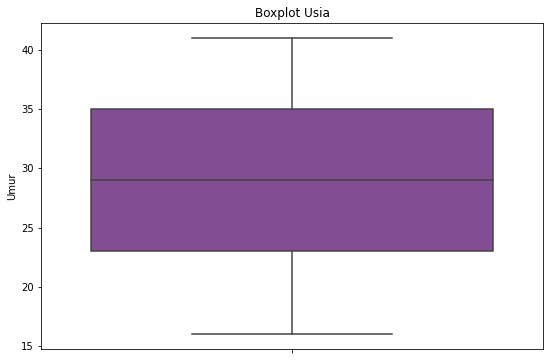

In [396]:
plt.figure(figsize=(9,6))
ax = sns.boxplot( y=final_df["Umur"] ,palette=sns.color_palette('BuPu_r', n_colors=3))
ax.set_title("Boxplot Usia")
ax.set_ylabel("Umur")
plt.savefig('Boxplot Usia.png')
plt.show()

** Pada boxplot dapat dilihat bahwa tidak ada outlier, karena memang sudah dibatasi dalam pembuatan dataset, jika dalam real maka outlier/pencilan akan terdapat diluar upper/ lower bound dari boxplot, perkiraan rata umur adalah 28, maksimum 41, dan minimum 16.

In [160]:
from scipy.stats import skew
age_df = pd.to_numeric(final_df['Umur'], errors='coerce')
print(f'Skweness of Age : {skew(age_df)}')

Skweness of Age : 0.01364095200786886


Tidak ada Skewness pada Data karena Nilai skewness < +1 dan > -1.

**Pisahkan Kategori Umur dalam berbagai kategori seperti (<17, Remaja, Dewasa).

In [163]:
bins=[16, 17, 30, 41]
labels=['<16', 'Remaja', 'Dewasa']
final_df['age_group'] = pd.cut(final_df['Umur'], bins, labels=labels)

In [164]:
final_df[['Umur','age_group']]

,Umur,age_group
0,20,Remaja
1,39,Dewasa
2,28,Remaja
3,17,<16
4,41,Dewasa
...,...,...
1927,31,Dewasa
1928,34,Dewasa
1929,30,Remaja
1930,30,Remaja


In [399]:
final_df['age_group'].value_counts()

Remaja    1025
Dewasa     821
<16         81
Name: age_group, dtype: int64

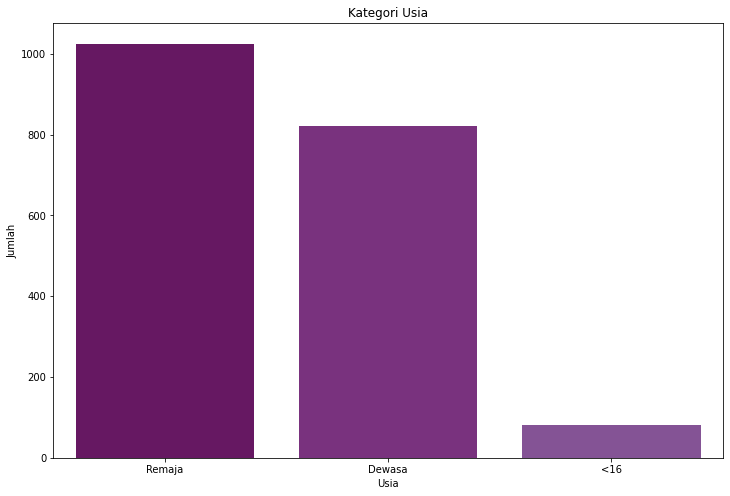

In [328]:
plt.figure(figsize=(12,8))
ax = sns.countplot((final_df['age_group']),order = final_df['age_group'].value_counts().index,palette=sns.color_palette('BuPu_r', n_colors=10))

# Customize the axes and title
ax.set_title("Kategori Usia")
ax.set_xlabel("Usia")
ax.set_ylabel("Jumlah")
plt.savefig('Kategori Usia.png')
plt.show()

Dapat dilihat bahwa usia Remaja menempati urutan pertama pengguna, sedangkan usia dibawah 17 Tahun memiliki jumlah porsi terkecil.

### Analysis Type dari Venue atau Lokasi.

In [166]:
final_df['Location Type'].nunique()

33

In [167]:
final_df['Location Type'].unique()

array(['Indonesian Restaurant', 'Hospital', 'Café', 'High School',
       'Hotel', 'School', "Doctor's Office", 'Medical Center',
       'Cafeteria', 'Multiplex', 'Gas Station',
       'Indonesian Meatball Place', 'Betawinese Restaurant',
       'Historic Site', 'Soup Place', 'Middle School', 'Intersection',
       'Sundanese Restaurant', 'Balinese Restaurant', 'Community College',
       'Padangnese Restaurant', 'Shopping Mall', 'Asian Restaurant',
       'Javanese Restaurant', 'Convenience Store',
       'Residential Building (Apartment / Condo)', 'Movie Theater',
       'Library', 'Building', 'Government Building', 'Office',
       'Grocery Store', 'Acehnese Restaurant'], dtype=object)

In [170]:
final_df['Location Type'].value_counts().nlargest(5)

Indonesian Restaurant    1032
Café                      434
Hospital                  259
High School               107
Medical Center             13
Name: Location Type, dtype: int64

**Dari keseluruhan Total 33 Location Type akan difilter top 5 terbanyak lokasi.

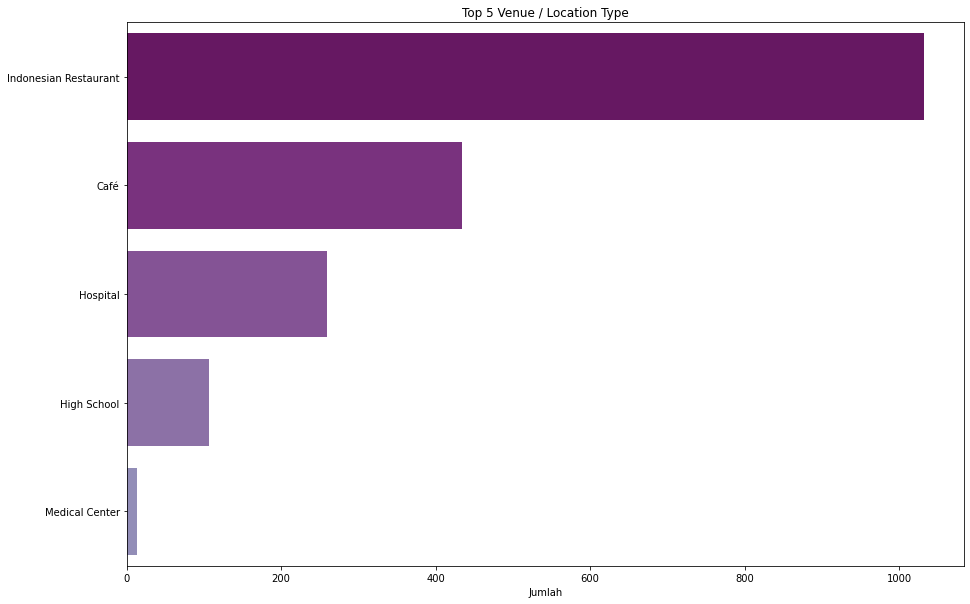

In [332]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x=final_df['Location Type'].value_counts().nlargest(5),y=final_df['Location Type'].value_counts().nlargest(5).index,palette=sns.color_palette('BuPu_r', n_colors=10) )
ax.set_title("Top 5 Venue / Location Type")
ax.set_xlabel("Jumlah")
plt.savefig('Top 5 Venue.png')
plt.show()

Hasil dari barplot menunjukkan bahwa pengguna kebanyakan Login melalui Restaurant.

### Analysis Type dari Venue atau Lokasi.

In [183]:
bins = [0, 6, 12, 18, 24]

# add custom labels if desired
labels = ['Pagi', 'Siang', 'Sore', 'Malam']
final_df['Time Bin'] = pd.cut(pd.to_datetime(final_df['Jam Login'], errors='coerce').dt.hour, bins, labels=labels, right=False)

In [185]:
final_df[['Jam Login','Time Bin']]

,Jam Login,Time Bin
0,21:39:34,Malam
1,06:19:41,Siang
2,14:35:59,Sore
3,14:57:22,Sore
4,11:50:46,Siang
...,...,...
1927,02:11:27,Pagi
1928,05:49:25,Pagi
1929,20:08:04,Malam
1930,03:16:40,Pagi


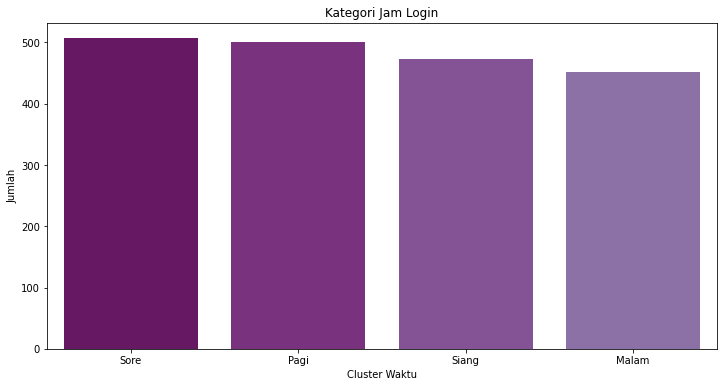

In [333]:
plt.figure(figsize=(12,6))
ax = sns.countplot((final_df['Time Bin']),order = final_df['Time Bin'].value_counts().index,palette=sns.color_palette('BuPu_r', n_colors=10))

# Customize the axes and title
ax.set_title("Kategori Jam Login")
ax.set_xlabel("Cluster Waktu")
ax.set_ylabel("Jumlah")
plt.savefig('Kategori Jam Login.png')
plt.show()

** Kebanyakan Pengguna Login pada Pagi dan Sore hari, dan tidak menutup kemungkinan banyak juga yang login pada tengah malam karena mungkin beberapa tempat buka 24 Jam.

## 2.2 Bivariate Analysis

### Jam Login vs Gender.

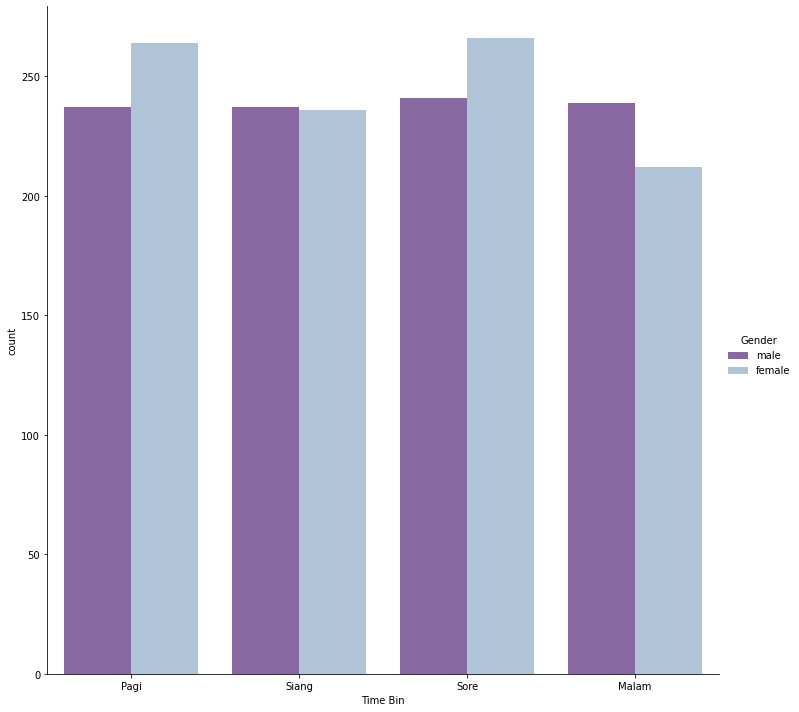

In [400]:
sns.catplot(x="Time Bin", hue="Gender", 
                 data=final_df, kind="count",
                 height=10,palette=sns.color_palette('BuPu_r', n_colors=2));
plt.savefig('Jam Login vs Gender.png')

** Berdasarkan Analysis dari dua variabel antara waktu login dan gender, kebanyakan wanita login pada pagi sampai malam hari, sedangkan pria lebih banyak bergadang pada malam sampai pagi hari.

### Jam Login vs Usia.

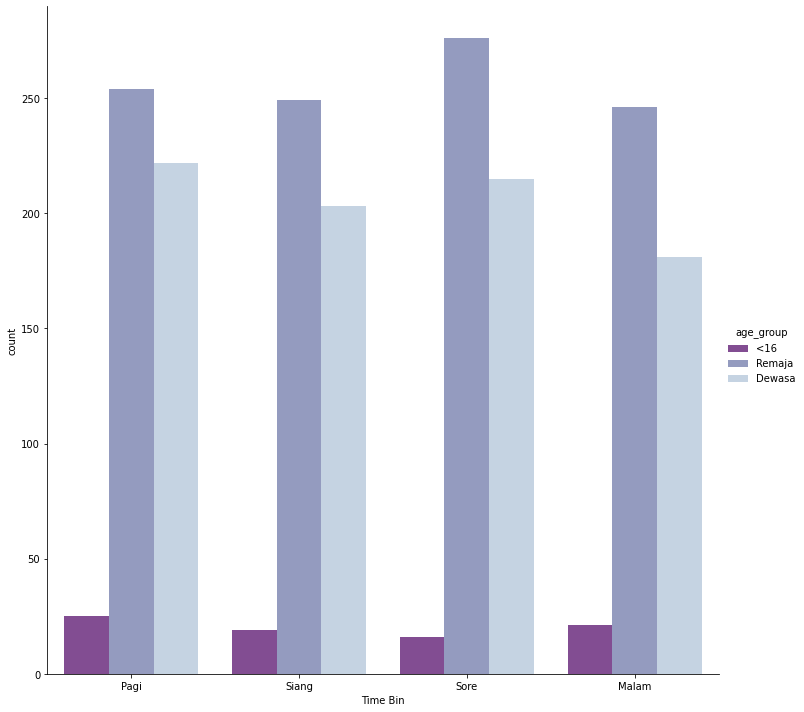

In [335]:
sns.catplot(x="Time Bin", hue="age_group", 
                 data=final_df, kind="count",
                 height=10,palette=sns.color_palette('BuPu_r', n_colors=3));
plt.savefig('Jam Login vs Usia.png')

** Pada seluruh jam login didominasi oleh remaja karena banyak remaja yang mungkin selalu aktif dalam bersosial media dan harus terkoneksi dengan internet terus.

In [ ]:
sns.catplot(x="Time Bin", hue="", 
                 data=final_df, kind="count",
                 height=10,palette=sns.color_palette('BuPu_r', n_colors=3));
plt.savefig('Jam Login vs Usia.png')

### Analysis Merk HP vs Gender.

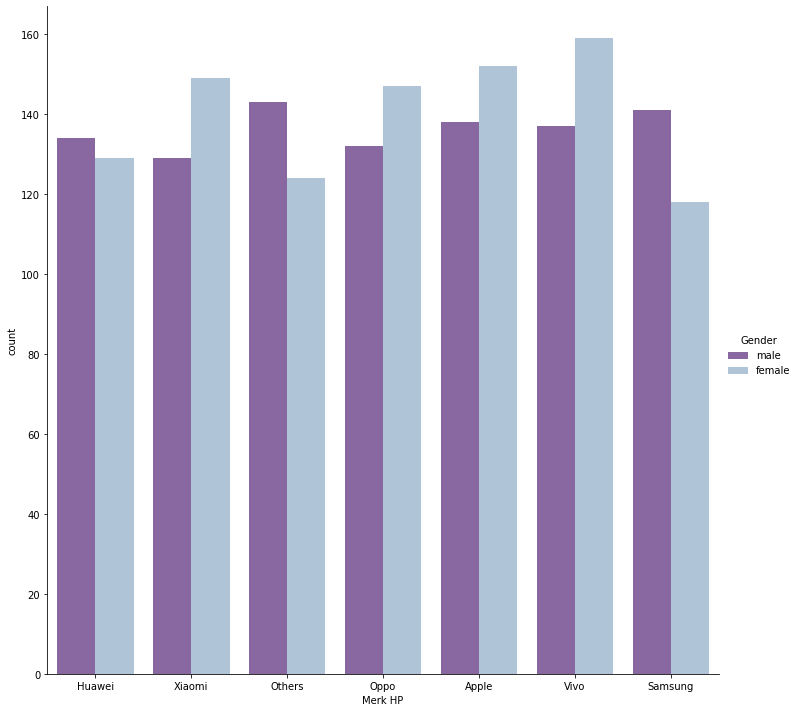

In [336]:
sns.catplot(x="Merk HP", hue="Gender", 
                 data=final_df, kind="count",
                 height=10,palette=sns.color_palette('BuPu_r', n_colors=2));
plt.savefig('Merk HP vs Gender.png')

** Pada Analysis Merk HP kebanyakan Wanita memilih brand HP seperti Iphone karena mungkin System Operasi IOS lebih mudah dibandingkan android, sedangkan laki2 cenderung banyak memilih HP seperti Samsung, Huawei.

### Analysis Regional vs Location Type.

In [225]:
final_df.groupby(['Regional'])['Location Type'].count().sort_values(ascending=False)

Regional
Jakarta Selatan    485
Jakarta Timur      415
Jakarta Pusat      400
Jakarta Barat      376
Jakarta Utara      256
Name: Location Type, dtype: int64

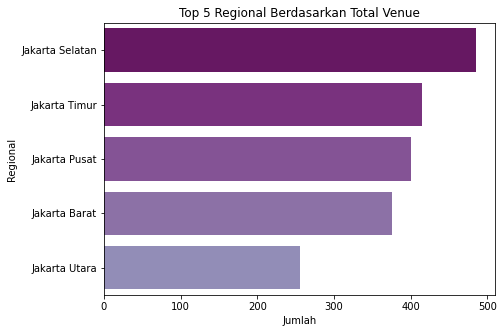

In [337]:
plt.figure(figsize=(7,5))
ax = sns.barplot(x=final_df.groupby(['Regional'])['Location Type'].count().sort_values(ascending=False),y=final_df.groupby(['Regional'])['Location Type'].count().sort_values(ascending=False).index,palette=sns.color_palette('BuPu_r', n_colors=10) )
ax.set_title("Top 5 Regional Berdasarkan Total Venue")
ax.set_xlabel("Jumlah")
plt.savefig('Top 5 Regional Berdasarkan Total Venue.png')
plt.show()

Analisis Untuk Semua regional di Jakarta, area Jakarta Selatan memiliki Jumlah Venue Terbanyak.

### All Jakarta Regions vs Location Type

<Figure size 1080x720 with 0 Axes>

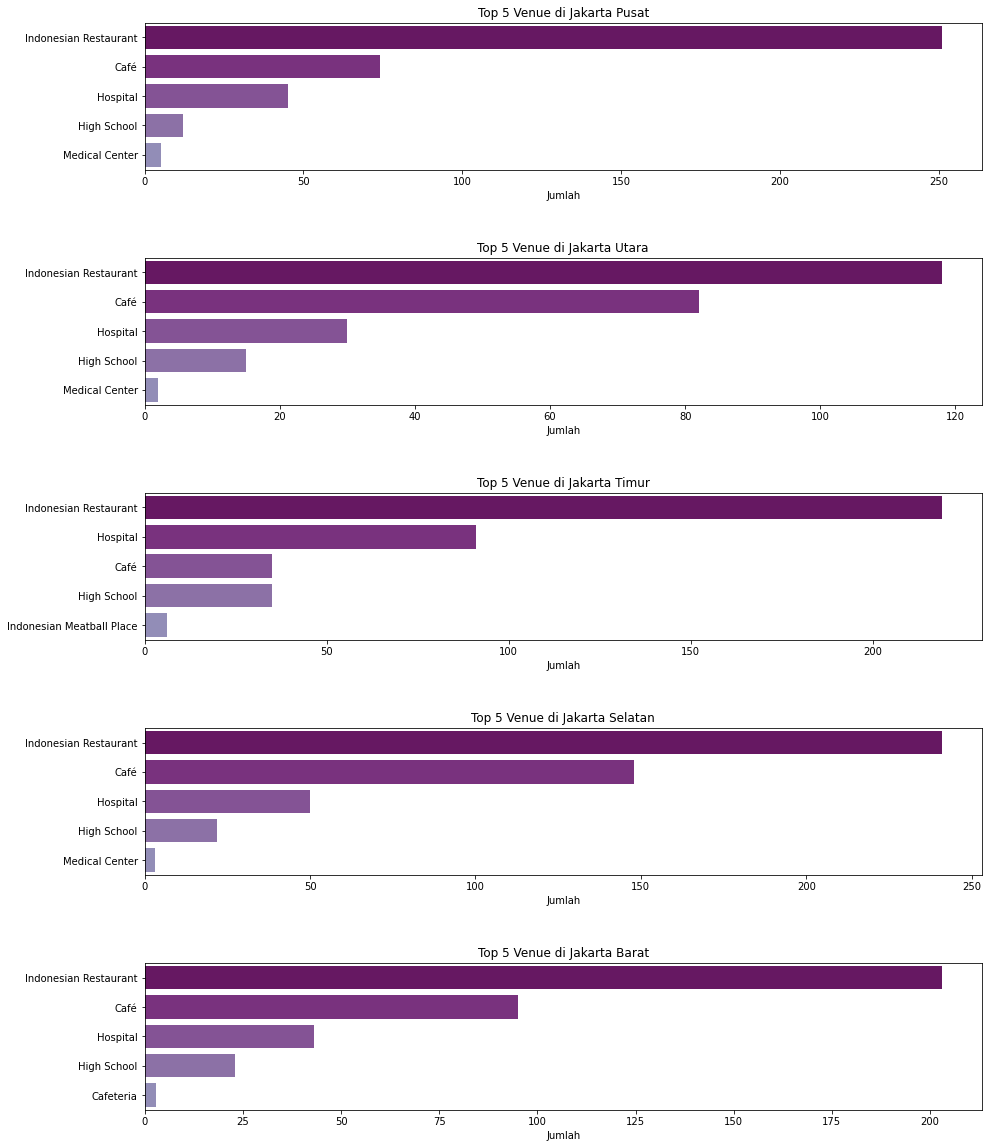

In [338]:
plt.figure(figsize=(15,10))

list = final_df['Regional'].unique().tolist()
fig, ax = plt.subplots(len(list),figsize=(15,20))
fig.subplots_adjust(hspace=.6)
                      
for i, col_val in enumerate(list):
    sns.barplot(x=final_df.loc[final_df['Regional'] == col_val]['Location Type'].value_counts().nlargest(5),y=final_df.loc[final_df['Regional'] == col_val]['Location Type'].value_counts().nlargest(5).index,ax=ax[i],palette=sns.color_palette('BuPu_r', n_colors=10))
    ax[i].set_title(f'Top 5 Venue di {col_val}')
    ax[i].set_xlabel("Jumlah")
plt.savefig('All Region vs Venue.png')
plt.show()

** Analysis Pada Seluruh Daerah Jakarta Indonesia restaurant menempati posisi pertama, kemudian didominasi oleh cafe / hospital, Jumlah terbanyak berada pada Jakarta Selatan dengan total 485 Venue.

## 3.1 Analysis Confidence Interval

In [282]:
import scipy

### Kolom Umur

In [289]:
final_df['Umur'].head()

0    20
1    39
2    28
3    17
4    41
Name: Umur, dtype: int64

In [367]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [368]:
m, lower, upper = mean_confidence_interval(final_df['Umur'])
print(f'Dengan Confidence 95% yakin bahwa rata rata pengukuran Umur untuk sample Berada pada {lower} dan {upper}')

Dengan Confidence 95% yakin bahwa rata rata pengukuran Umur untuk sample Berada pada 28.507749136228718 dan 29.14442477681476


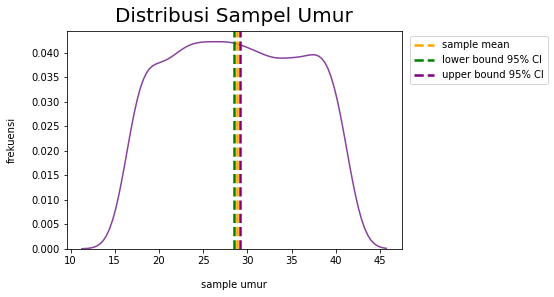

In [402]:
sns.distplot(final_df['Umur'], hist=False)
plt.title("Distribusi Sampel Umur", y=1.015, fontsize=20)
plt.axvline(x=m, linestyle='--', linewidth=2.5, label="sample mean ", c='orange')
plt.axvline(x=lower, linestyle='--', linewidth=2.5, label="lower bound 95% CI", c='g')
plt.axvline(x=upper, linestyle='--', linewidth=2.5, label="upper bound 95% CI", c='purple')
plt.xlabel("sample umur", labelpad=14)
plt.ylabel("frekuensi", labelpad=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left");
plt.savefig('CI UMUR.png',bbox_inches = 'tight')

**Semakin tinggi confidence Interval akan semakin lebar jarak upper dan lower bound true mean nya.

### Kolom Jam Login

In [372]:
split_jam = final_df['Jam Login'].str.split(':').str[0]

In [379]:
split_jam = pd.to_numeric(split_jam,errors='coerce')

In [385]:
m_Jam, lowerJam, upperJam = mean_confidence_interval(split_jam)
print(f'Dengan Confidence 95% yakin bahwa rata rata pengukuran Jam untuk sample Berada pada {lowerJam} dan {upperJam}')

Dengan Confidence 95% yakin bahwa rata rata pengukuran Jam untuk sample Berada pada 11.047726167723415 dan 11.659313169750707


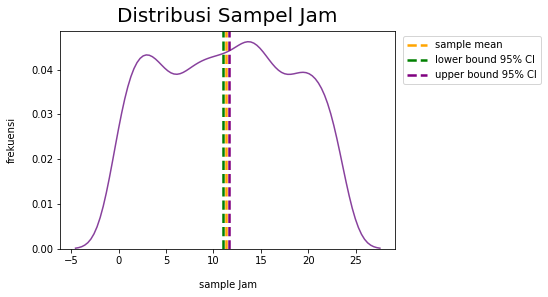

In [403]:
sns.distplot(split_jam, hist=False)
plt.title("Distribusi Sampel Jam", y=1.015, fontsize=20)
plt.axvline(x=m_Jam, linestyle='--', linewidth=2.5, label="sample mean ", c='orange')
plt.axvline(x=lowerJam, linestyle='--', linewidth=2.5, label="lower bound 95% CI", c='g')
plt.axvline(x=upperJam, linestyle='--', linewidth=2.5, label="upper bound 95% CI", c='purple')
plt.xlabel("sample Jam", labelpad=14)
plt.ylabel("frekuensi", labelpad=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.savefig('CI Jam.png',bbox_inches = 'tight')

## 3.2 Analysis Clustering Area

In [305]:
venue_kecamatan = pd.DataFrame(final_df.groupby(['Kecamatan'])['Location Type'].count().sort_values(ascending=False)).reset_index()

In [315]:
venue_kecamatan.head(5)

,Kecamatan,Location Type
0,Tebet,50
1,Menteng,50
2,Gambir,50
3,Grogol Petamburan,50
4,Cilandak,50


In [314]:
venue_kecamatan.tail()

,Kecamatan,Location Type
37,Jagakarsa,35
38,Cengkareng,34
39,Pasar Rebo,31
40,Cakung,18
41,Cilincing,17


Analisis pada setiap kecamatan rata rata memiliki total 50 venue dengan kombinasi berdasarkan radius tertentu, nilai 50 ini karena saat pembuatan dataset dari API foursquare diset nilai 50. tetapi pada beberapa daerah memang search radius tersebut venue sudah maksimum dan tidak mencapai 50.

In [307]:
final_df2 = final_df.merge(venue_kecamatan, on='Kecamatan', how='inner')

**Rename Columns name setelah Inner join, karena pandas otomatis memberikan nilai x/y pada nama kolom ketika tidak di specify.

In [319]:
final_df2 = final_df2.rename(columns={'Location Type_x': 'Location Type', 'Location Type_y': 'Count Venue'})

In [ ]:
import plotly.express as px

In [339]:
fig = px.density_mapbox(final_df2, lat='Lokasi Latitude', lon='Lokasi Longitude', z='Count Venue', radius=10,
                        center=dict(lat=0, lon=180), zoom=0,
                        mapbox_style="stamen-terrain")
plt.savefig('HeatmapGeo.png')
fig.show()

<Figure size 432x288 with 0 Axes>

** Analysis pada Density Plot beberapa kecamatan yang memiliki Venue > 50 akan berwarna terang, sedangkan di beberapa titik seperti di Jakarta Utara misalnya 'Cilincing' memiliki venue kurang dari 50 maka berwarna lebih gelap.

In [353]:
final_df2.to_excel(r'Final_data.xlsx', index = False)